In [1]:
import torch
import torch.nn as nn
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import torch as th

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dtype = torch.double

In [2]:
# read in data
r_hat = torch.load('tensor_data/r_hat-torch.th')
s_hat = torch.load('tensor_data/s_hat-torch.th')
# b = torch.load('tensor_data/b_DNS-torch.th')
# grid = torch.load('tensor_data/grid-torch.th')

inv_scaled = torch.load('tensor_data/post_interpolation/inv-torch.th')
T = torch.load('tensor_data/post_interpolation/T-torch.th').reshape(-1,10,9)
b = torch.load('tensor_data/post_interpolation/b_DNS-torch.th')
grid = torch.load('tensor_data/post_interpolation/grid-torch.th')

# N is number of input point, D_in is input size, D_out is output size, H is hidden dimension
N = inv_scaled.shape[0]
D_in, D_out = 5, 10
H = 200

#### Basis tensors $T_i$:


\begin{align}
    T_1 &= \hat S \\
    T_2 &= \hat S \hat \Omega - \hat \Omega \hat S \\
    T_3 &= \hat S^2 - \frac{1}{3} \mathrm{tr} (\hat S^2)I \\
    T_4 &= \hat \Omega^2 - \frac{1}{3} \mathrm{tr} (\hat \Omega^2)I\\
    T_5 &= \hat \Omega \hat S^2 - \hat S^2 \Omega \\
    T_6 &= \hat \Omega^2 \hat S + \hat S \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S \hat \Omega^2)I \\
    T_7 &= \hat \Omega \hat S \hat \Omega^2 - \hat \Omega^2 \hat S \hat \Omega \\
    T_8 &= \hat S \hat \Omega \hat S^2 - \hat S^2 \hat \Omega \hat S \\
    T_9 &= \hat \Omega^2 \hat S^2 + \hat S^2 \hat \Omega^2 - \frac{2}{3} \mathrm{tr} (\hat S^2 \hat \Omega^2)I \\
    T_{10} &= \hat \Omega \hat S^2 \hat \Omega^2 - \hat \Omega^2 \hat S^2 \hat \Omega
\end{align}

In [3]:
def getInvariants(s0, r0):
    """function for computation of tensor basis
        Inputs:
            s0: N x 3 x 3 (N is number of datapoints)
            r0: N x 3 x 3
        Outputs:
            invar_sig : N x 5 (5 is number of scalar invariants)
    """
    nCells = s0.size()[0]
    invar = th.zeros(nCells, 5).type(dtype)

    s2 = s0.bmm(s0)
    r2 = r0.bmm(r0)
    s3 = s2.bmm(s0)
    r2s = r2.bmm(s0)
    r2s2 = r2.bmm(s2)

    invar[:,0] = (s2[:,0,0]+s2[:,1,1]+s2[:,2,2]) #Tr(s2)
    invar[:,1] = (r2[:,0,0]+r2[:,1,1]+r2[:,2,2]) #Tr(r2)
    invar[:,2] = (s3[:,0,0]+s3[:,1,1]+s3[:,2,2]) #Tr(s3)
    invar[:,3] = (r2s[:,0,0]+r2s[:,1,1]+r2s[:,2,2]) #Tr(r2s)
    invar[:,4] = (r2s2[:,0,0]+r2s2[:,1,1]+r2s2[:,2,2]) #Tr(r2s2)

    # Scale invariants by sigmoid function
    # Can use other scalings here
    invar_sig = (1.0 - th.exp(-invar))/(1.0 + th.exp(-invar))
    invar_sig[invar_sig != invar_sig] = 0

    return invar_sig
    
def getTensorFunctions(s0, r0):
    """function for computation of tensor basis
        Inputs:
            s0: N x 3 x 3 (N is number of datapoints)
            r0: N x 3 x 3
        Outputs:
            T : N x 10 x 3 x 3 (10 is number of basis tensors)
    """
    
    nCells = s0.size()[0]
    T = th.zeros(nCells,10,3,3).type(dtype)

    s2 = s0.bmm(s0)
    r2 = r0.bmm(r0)
    sr = s0.bmm(r0)
    rs = r0.bmm(s0)

    T[:,0] = s0
    T[:,1] = sr - rs
    T[:,2] = s2 - (1.0/3.0)*th.eye(3).type(dtype)*(s2[:,0,0]+s2[:,1,1]+s2[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,3] = r2 - (1.0/3.0)*th.eye(3).type(dtype)*(r2[:,0,0]+r2[:,1,1]+r2[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,4] = r0.bmm(s2) - s2.bmm(r0)
    t0 = s0.bmm(r2)
    T[:,5] = r2.bmm(s0) + s0.bmm(r2) - (2.0/3.0)*th.eye(3).type(dtype)*(t0[:,0,0]+t0[:,1,1]+t0[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,6] = rs.bmm(r2) - r2.bmm(sr)
    T[:,7] = sr.bmm(s2) - s2.bmm(rs)
    t0 = s2.bmm(r2)
    T[:,8] = r2.bmm(s2) + s2.bmm(r2) - (2.0/3.0)*th.eye(3).type(dtype)*(t0[:,0,0]+t0[:,1,1]+t0[:,2,2]).unsqueeze(1).unsqueeze(1)
    T[:,9] = r0.bmm(s2).bmm(r2) + r2.bmm(s2).bmm(r0)

    # Scale the tensor basis functions by the L2 norm
    l2_norm = th.zeros(T.size(0), 10)
    l2_norm = 0
    for (i, j), x in np.ndenumerate(np.zeros((3,3))):
        l2_norm += th.pow(T[:,:,i,j],2)
    T = T/th.sqrt(l2_norm).unsqueeze(2).unsqueeze(3)

    return T

In [4]:
# get invariants
# inv_scaled = getInvariants(s_hat, r_hat)

# # get tensor basis
# T = getTensorFunctions(s_hat, r_hat).flatten(2)

# inv_scaled = torch.tanh(inv)
# inv_scaled.requires_grad=True

**Nick Genevas implementation of the NN:**

In [5]:
import torch as th
# Turbulence Neural network
class TurbNN(torch.nn.Module):

    def __init__(self, D_in, H, D_out):
        """
        Architecture of the turbulence deep neural net
        Args:
            D_in (Int) = Number of input parameters
            H (Int) = Number of hidden paramters
            D_out (Int) = Number of output parameters
        """
        super(TurbNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.f1 = th.nn.LeakyReLU()
        self.linear2 = th.nn.Linear(H, H)
        self.f2 = th.nn.LeakyReLU()
        self.linear3 = th.nn.Linear(H, H)
        self.f3 = th.nn.LeakyReLU()
        self.linear4 = th.nn.Linear(H, H)
        self.f4 = th.nn.LeakyReLU()
        self.linear5 = th.nn.Linear(H, int(H/5))
        self.f5 = th.nn.LeakyReLU()
        self.linear6 = th.nn.Linear(int(H/5), int(H/10))
        self.f6 = th.nn.LeakyReLU()
        self.linear7 = th.nn.Linear(int(H/10), D_out)

    def forward(self, x):
        """
        Forward pass of the neural network
        Args:
            x (th.DoubleTensor): [N x D_in] column matrix of training inputs
        Returns:
            out (th.DoubleTensor): [N x D_out] matrix of neural network outputs
        """
        lin1 = self.f1(self.linear1(x))
        lin2 = self.f2(self.linear2(lin1))
        lin3 = self.f3(self.linear3(lin2))
        lin4 = self.f4(self.linear4(lin3))
        lin5 = self.f5(self.linear5(lin4))
        lin6 = self.f6(self.linear6(lin5))
        out = self.linear7(lin6)

        return out

In [6]:
class FoamSVGD():
    def __init__(self):
        self.turb_nn = TurbNN(D_in=5, H=200, D_out=10).float() #Construct neural network
    
    def forward(self, inv, t_data):
        out_size = (3,3)
        output = th.Tensor(inv.shape[0], *out_size).type(dtype)
        g_pred = self.turb_nn.forward(inv)
        g_pred0 = th.unsqueeze(th.unsqueeze(g_pred, 2), 3)
        output = th.sum(g_pred0 * t_data, 1)
        return output

**My own implementation of NN**

changed the output of the NN to also give out $G$ tensor

In [7]:
class TBNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TBNN, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden_layer_1 = torch.nn.Linear(H, H)
        self.hidden_layer_2 = torch.nn.Linear(H, H)
        self.hidden_layer_3 = torch.nn.Linear(H, H)
        self.hidden_layer_4 = torch.nn.Linear(H, int(H/2))
        self.hidden_layer_5 = torch.nn.Linear(int(H/2), int(H/4))
        self.hidden_layer_6 = torch.nn.Linear(int(H/4), int(H/8))
        self.output_linear = torch.nn.Linear(int(H/8), D_out)
        self.NN = torch.nn.Sequential(self.input_layer,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_1,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_2,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_3,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_4,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_5,
                                      torch.nn.LeakyReLU(),
                                      self.hidden_layer_6,
                                      torch.nn.LeakyReLU(),
                                      self.output_linear)
        
    def forward(self, inv, T):
        G = self.NN(inv)
        G0 = G.unsqueeze(2).expand(inv.shape[0],10,9)
        return (G0*T).sum(dim=1), G

In [8]:
# create model instance
model = TBNN(D_in, H, D_out).double()
loss_fn = torch.nn.MSELoss(reduction='sum')

# reshape b tensor in case of own NN
b = b.flatten(1) #.float()
b.requires_grad = False

# split data into training and test data. set random_state to ensure getting same dataset for debugging
inv_train, inv_val, T_train, T_val, b_train, b_val = train_test_split(inv_scaled, T, b,
                                                                         test_size=240, random_state=42)
inv_train.requires_grad=True

## L2 regularization
lmbda = 1e-4 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

In [9]:
# create instant of foamsvgd
NN = FoamSVGD()

**Setting up optimization parameters and starting loop**

In [10]:
# set training parameters
learning_rate = 5e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # model / model.parameters() NN.turb_nn.parameters()
# niters = 10000 # int(100/learning_rate)
batchsize = 20
nepochs = 200

In [11]:
# better implementation of mini batching with disjoint mini batches

# initialize tensor to store G tensors from NN
G = torch.zeros(int(nepochs/20),N,10)

# initialize training loss
perm = np.random.permutation(inv_train.shape[0])
initial_inv = inv_train[perm[0:20]]
initial_T = T_train[perm[0:20]]
initial_b = b_train[perm[0:20]]
initial_pred, _ = model(initial_inv, initial_T)
loss_vector = loss_fn(initial_pred, initial_b).detach().numpy()

# initialize validation loss
b_val_pred, _ = model(inv_val, T_val)
val_loss_vector = loss_fn(b_val_pred, b_val).detach().numpy()

# run loop over all epochs
for epoch in range(nepochs):
    
    # random permutation of training data before every epoch
    N_train = inv_train.shape[0]
    perm = np.random.permutation(N_train)
    batch_size = batchsize  # int(N_train/100)
    
    # loop over all batches in one epoch
    for it in range(0, N_train, batch_size):
        # get batch data
        idx = perm[np.arange(it,it + batch_size)]
        inv_batch = inv_train[idx,:]
        T_batch = T_train[idx,:,:]
        b_batch = b_train[idx,:]
        
        # Forward pass
        b_pred, _ = model(inv_batch, T_batch)
        # b_pred = NN.forward(inv_batch, T_batch.reshape(-1,10,3,3))
        
        # compute and print loss
        loss = loss_fn(b_pred, b_batch) # + L2loss(lmbda, model)
        
        # reset gradient buffer
        optimizer.zero_grad()
        
        # get gradient
        loss.backward()
        
        # optimization step
        optimizer.step()
    
    # append loss to loss vector
    loss_vector = np.append(loss_vector, loss.detach().numpy())
    
    # compute validation error
    b_val_pred, _ = model(inv_val, T_val)
    val_loss_vector = np.append(val_loss_vector, loss_fn(b_val_pred, b_val).detach().numpy())
    
    # output optimization state
    if (epoch) % 20 == 0:
        print('Epoch: {}, Training loss: {:.6f}, Validation loss {:.6f}'.format(epoch, loss.item(), val_loss_vector[-1]))
        _, G_epoch = model(inv_scaled, T)
        G[int((epoch+1)/20)] = G_epoch

Epoch: 0, Training loss: 3.839392, Validation loss 44.985850
Epoch: 20, Training loss: 2.623029, Validation loss 32.321908
Epoch: 40, Training loss: 1.736824, Validation loss 20.721258
Epoch: 60, Training loss: 1.671441, Validation loss 20.072535
Epoch: 80, Training loss: 1.671477, Validation loss 20.065141
Epoch: 100, Training loss: 1.671587, Validation loss 20.061689
Epoch: 120, Training loss: 1.671481, Validation loss 20.057560
Epoch: 140, Training loss: 1.670871, Validation loss 20.053614
Epoch: 160, Training loss: 1.671319, Validation loss 20.049043
Epoch: 180, Training loss: 1.672171, Validation loss 20.045726


In [12]:
# save G for later usage
# torch.save(G, 'tensor_data/G_10000_1e-5_tanh.th')
G.detach().numpy()[1,:,0].reshape(30,30).shape

(30, 30)

## Visualization of training process and results

**Training Process**

Text(0, 0.5, 'MSPE')

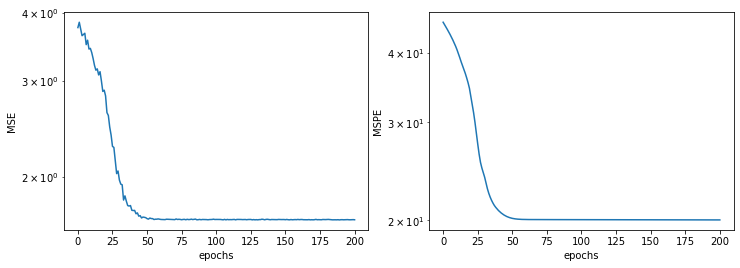

In [13]:
# plot the training and validation error
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].semilogy(np.arange(loss_vector.shape[0]), loss_vector)
ax[0].set_xlabel(r'epochs')
ax[0].set_ylabel(r'MSE')

ax[1].semilogy(np.arange(val_loss_vector.shape[0]), val_loss_vector)
ax[1].set_xlabel(r'epochs')
ax[1].set_ylabel(r'MSPE')


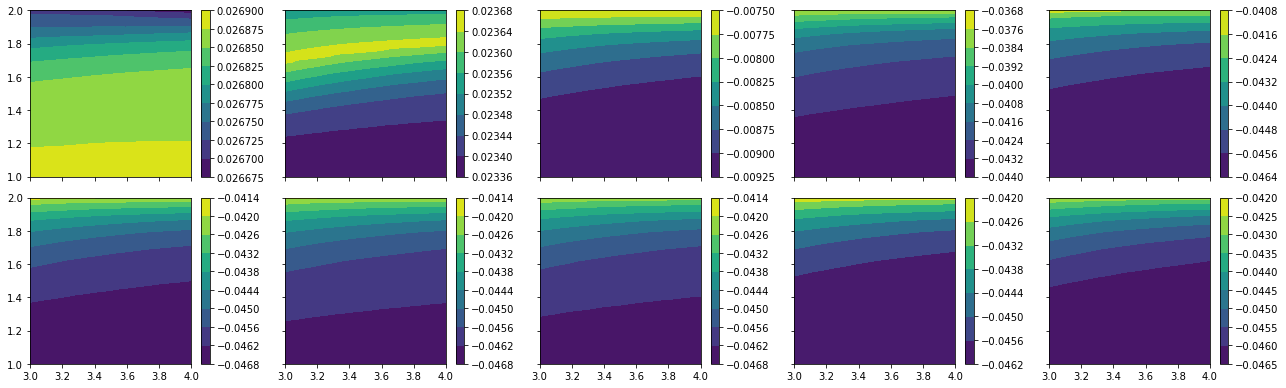

In [14]:
# Output of NN (G)
# Make grid for contour plots
fig, axs = plt.subplots(2, 5, figsize=(18,5.5), sharex=True, sharey=True, tight_layout=True)
grid_x, grid_y = np.mgrid[3.:4.:30j, 1.:2.:30j]

# loop through all saved states of G
for i,ax in enumerate(axs.flat):
    G_plt = ax.contourf(grid_x, grid_y, G.detach().numpy()[i,:,1].reshape(30,30))
    fig.colorbar(G_plt, ax=ax)

### Input Data

**Invariants**

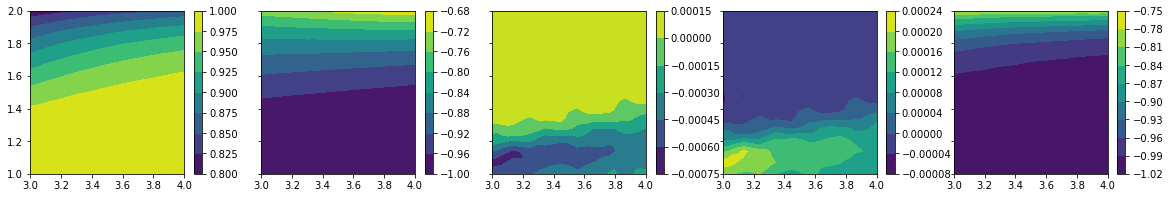

In [15]:
# visualize all invariants
# grid_x, grid_y = np.mgrid[3.:4.:30j, 1.:2.:30j]
# grid_x, grid_y = np.mgrid[1.:8.:100j, 1.:2.5:30j]
fig, axs = plt.subplots(1,5, figsize=(20,3), sharex=True, sharey=True)

for i in range(5):
    grid_inv = griddata(grid, inv_scaled.detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    inv_plt = axs.flat[i].contourf(grid_x, grid_y, grid_inv)
    fig.colorbar(inv_plt, ax=axs.flat[i])

**Tensor basis**

In [16]:
# # visualize all tensor components of the tensor basis
# grid_x, grid_y = np.mgrid[3:4:100j, 1:2:100j]

# for j in range(10):
#     fig, axs = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
#     fig.suptitle(r'$T_{}$'.format(j+1), fontsize=10)
#     for i in range(9):
#         grid_z1 = griddata(grid, T.detach().numpy()[:,j,i], (grid_x, grid_y), method='linear')
#         T_plt = axs.flat[i].contourf(grid_x, grid_y, grid_z1)
#         fig.colorbar(T_plt, ax=axs.flat[i])

### Results
**anisotropy tensor $b$**

In [17]:
# get predicted b
b_pred, _ = model(inv_scaled,T) # .reshape(-1,9)

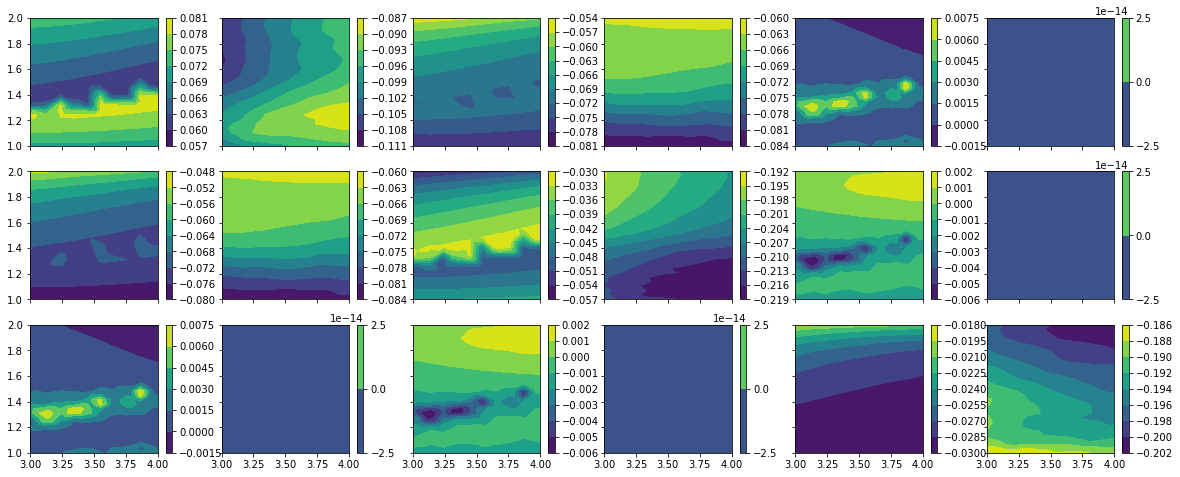

In [18]:
# visualize all tensor components of b_pred (uneven index) and b (even index)
# index runs through one line of the figure after another

fig, axs = plt.subplots(3,6, figsize=(20,8), sharex=True, sharey=True)

# remove flatten(1) when not using genevas NN
for i in range(9):
    grid_z1 = griddata(grid, b_pred.flatten(1).detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    grid_z2 = griddata(grid, b.flatten(1).detach().numpy()[:,i], (grid_x, grid_y), method='linear')
    R_nn = axs.flat[2*i].contourf(grid_x, grid_y, grid_z1)
    R_dns = axs.flat[2*i+1].contourf(grid_x, grid_y, grid_z2)
    fig.colorbar(R_nn, ax=axs.flat[2*i])
    fig.colorbar(R_dns, ax=axs.flat[2*i+1])

## Older code snittpets that are not in use right now

In [19]:
# class TBNN_generic(nn.Module):
#     """
#     An implementation of a fully connected feed forward 
#     Neural network in pytorch. 
#     """
#     def __init__(self, layersizes=[1, 1], 
#                  activation=torch.relu,
#                  final_layer_activation=None):
#         """
#         INPUTS:
#             layersizes <list/tuple>: An iterable ordered object containing
#                                  the sizes of the tensors from the
#                                  input layer to the final output. 
#                                  (See example below). 
#             activation <callable>: A python callable through which
#                                     torch backpropagation is possible.
#             final_layer_activation <callable>: A python callable for 
#                                     the final layer activation function.
#                                     Default: None (for regression problems)
        
#         EXAMPLE: 
#             To define a NN with an input of size 2, 2 hidden layers of size 
#             50 and 50, output of size 1, with tanh activation function: 
#             >> layers = [2, 50, 50, 1]
#             >> neuralnet = NeuralNet(layers, activation=torch.tanh)
#             >> x = torch.randn(100, 2)   # 100 randomly sampled inputs 
#             >> output = neuralnet(x)  # compute the prediction at x.
        
#         Inheriting from nn.Module ensures that all
#         NN layers defined within the __init__ function are captured and 
#         stored in an OrderedDict object for easy accesability.
#         """
#         super(TBNN_generic, self).__init__()
#         self.layersizes = layersizes
#         self.input_dim = self.layersizes[0]
#         self.hidden_sizes = self.layersizes[1:-1]
#         self.output_dim = self.layersizes[-1]
#         self.activation = activation
#         self.final_layer_activation = final_layer_activation
#         if self.final_layer_activation is None:
#             self.final_layer_activation = nn.Identity()
#         self.nlayers = len(self.hidden_sizes) + 1
#         self.layernames = [] ## Dictionary to store all the FC layers 
        
#         # define FC layers
#         for i in range(self.nlayers):
#             layername = 'fc_{}'.format(i+1)
#             layermodule = nn.Linear(self.layersizes[i], self.layersizes[i+1])
#             self.layernames.append(layername)
#             setattr(self, layername, layermodule)
        
#     def forward(self, inv, T):
#         """
#         Implement the forward pass of the NN. 
#         """
#         for i, layername in enumerate(self.layernames):
#             fclayer = getattr(self, layername)
#             inv = fclayer(inv)
#             if i == self.nlayers - 1:
#                 inv = self.final_layer_activation(inv)
#             else:
#                 inv = self.activation(inv)
                
#         G = inv.unsqueeze(2).expand(inv.shape[0],10,9)
#         return (G*T).sum(dim=1)
    
# model_2 = TBNN_generic([D_in, H, H, int(H/2), int(H/4), D_out], torch.tanh)
# # for m in model_2.modules():
# #     print(m)


In [20]:
# # how to print model parameters
# a = TurbNN(D_in=5, H=200, D_out=10).float()
# for n, p in a.named_parameters():
#     print(n)

In [21]:
# # how to print model parameters
# for n, p in model.named_parameters():
#     print(n)

In [22]:
# second implementation with simple mini batching
# for i in range(niters):
#     # sample batch batch of data
#     inv_batch, _, T_batch, _, b_batch, _ = train_test_split(inv_train, T_train, b_train, test_size=batchsize)
    
#     inv_batch.requires_grad = True
    
#     # Forward pass
#     b_pred = model(inv_batch,T_batch)
    
#     # Compute and print loss
#     loss = loss_fn(b_pred, b_batch) # + L2loss(lmbda, model)
#     if i % 1000 == 0:
#         print(i, loss.item())
      
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [23]:
# first implementation without mini batches
# for i in range(niters):
#     # Forward pass
#     b_pred = model(inv_scaled,T)
    
#     # Compute and print loss
#     loss = loss_fn(b_pred, b) # + L2loss(lmbda, model)
#     if i % 1000 == 0:
#         print(i, loss.item())
      
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#### Former computation of inv and T

In [24]:
# # initialize feature set (invariants)
# inv = torch.zeros(N, 5, dtype=dtype, requires_grad=False) #

# # compute feature set
# inv[:,0] = torch.from_numpy(np.array(s_hat.matmul(s_hat)).trace(axis1=1, axis2=2))
# inv[:,1] = torch.from_numpy(np.array(r_hat.matmul(r_hat)).trace(axis1=1, axis2=2))
# inv[:,2] = torch.from_numpy(np.array(s_hat.matmul(s_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
# inv[:,3] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat))).trace(axis1=1, axis2=2))
# inv[:,4] = torch.from_numpy(np.array(r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat)))).trace(axis1=1, axis2=2))

# # normalize feature set
# inv_scaled = norm_sigmoid(inv)
# # inv_scaled = torch.tanh(inv)
# # inv_scaled.requires_grad=True

In [25]:
# # initialize tensor basis
# T = torch.zeros(N, 10, 9, dtype=dtype, requires_grad=False)

# # compute tensor basis
# T[:,0,:] = s_hat.flatten(1)  # s_hat
# T[:,1,:] = (s_hat.matmul(r_hat) - r_hat.matmul(s_hat)).flatten(1)
# T[:,2,:] = (s_hat.matmul(s_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
#             inv[:,0].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
# T[:,3,:] = (r_hat.matmul(r_hat) - 1/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)* \
#             inv[:,1].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
# T[:,4,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))).flatten(1)
# T[:,5,:] = (r_hat.matmul(s_hat.matmul(s_hat)) - s_hat.matmul(s_hat.matmul(r_hat))
#             - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,3].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
# T[:,6,:] = (r_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat))) - r_hat.matmul(r_hat.matmul(s_hat.matmul(r_hat)))).flatten(1)
# T[:,7,:] = (s_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) - s_hat.matmul(s_hat.matmul(r_hat.matmul(s_hat)))).flatten(1)
# T[:,8,:] = (r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat))) + s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))
#        - 2/3 * torch.eye(3).reshape(1,3,3).repeat(N,1,1)*inv[:,4].unsqueeze(1).unsqueeze(2).expand(N,3,3)).flatten(1)
# T[:,9,:] = (r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat.matmul(r_hat)))) \
#             - r_hat.matmul(r_hat.matmul(s_hat.matmul(s_hat.matmul(r_hat))))).flatten(1)

# # normalize tensor basis by spectral norm
# for i in range(T.shape[1]):
#     T[:,i,:] = T[:,i,:] / torch.tensor(la.norm(T[:,i,:].reshape(-1,3,3), ord=2, axis=(1,2))).unsqueeze(1).expand(N,9)